In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


seed = 2019
np.random.seed(seed)
%matplotlib inline

In [10]:
dirname = 'C:/Users/rituj/Downloads/oct/OCT2017/OCT2017/'
train_path = os.path.join(dirname, 'train')
train_normal_pth = os.path.join(train_path, 'NORMAL')
train_dme_pth = os.path.join(train_path, 'DME')
train_drusen_pth = os.path.join(train_path, 'DRUSEN')
train_cnv_pth = os.path.join(train_path, 'CNV')

test_path = os.path.join(dirname, 'test')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')
input_path = 'C:/Users/rituj/Downloads/oct/OCT2017/OCT2017/'

train, Normal images: 26315, DME images: 11348, DRUSEN images: 8616, CNV images: 37205
test, Normal images: 250, DME images: 250, DRUSEN images: 250, CNV images: 250


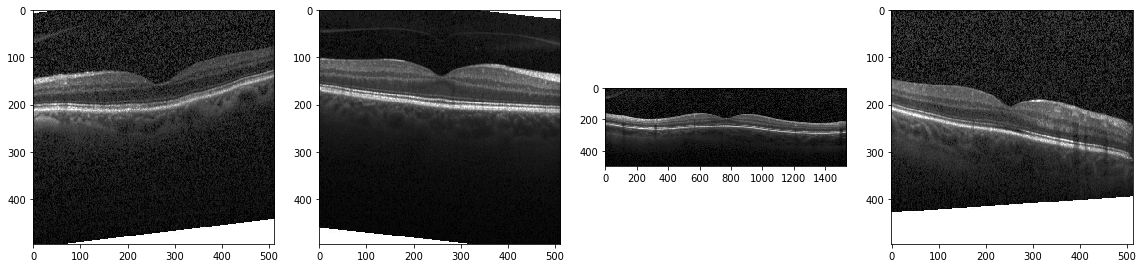

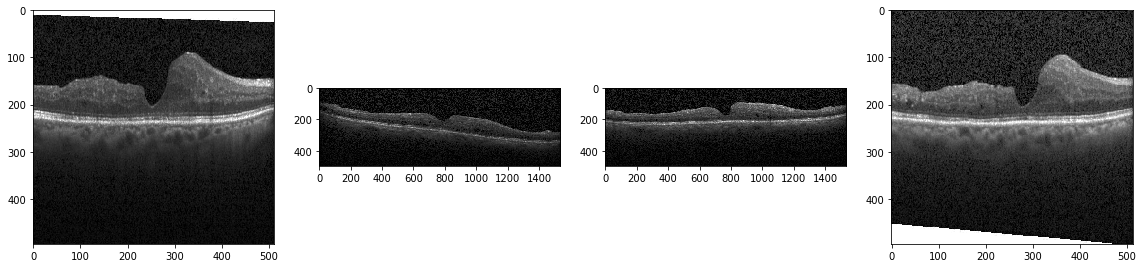

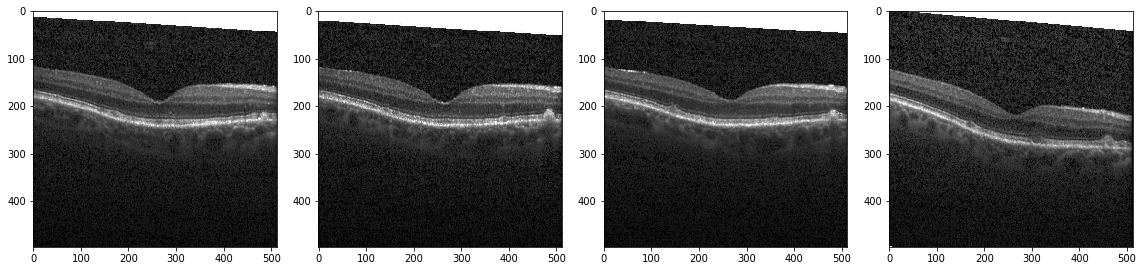

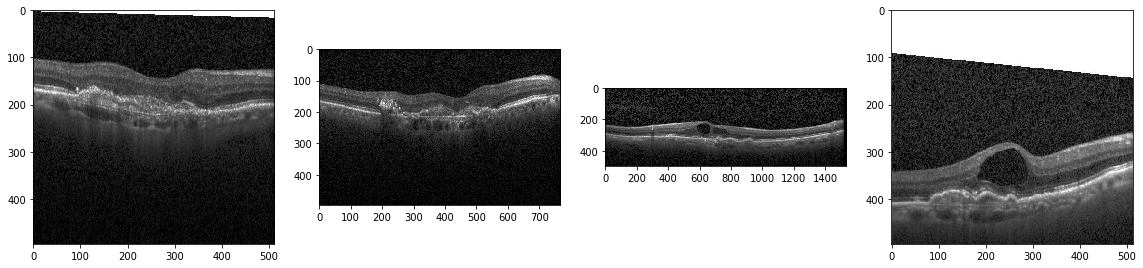

In [11]:

class pre:
    
    def plot_imgs(item_dir, num_imgs=4):
        all_item_dirs = os.listdir(item_dir)
        item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

        plt.figure(figsize=(16, 16))
        for idx, img_path in enumerate(item_files):
            plt.subplot(1, 4, idx+1)

            img = plt.imread(img_path)
            plt.imshow(img, cmap='gray')

        plt.tight_layout()
    plot_imgs(train_normal_pth)
    plot_imgs(train_dme_pth)
    plot_imgs(train_drusen_pth)
    plot_imgs(train_cnv_pth)
    
    for _set in ['train', 'test']:
        normal = len(os.listdir(input_path + _set + '/NORMAL'))
        dme = len(os.listdir(input_path + _set + '/DME'))
        drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
        cnv = len(os.listdir(input_path + _set + '/CNV'))
        print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))
    @staticmethod     
    def process_data(img_dims, batch_size):
        # Data generation objects
        train_datagen = ImageDataGenerator(
            rescale = 1./255,
          #  featurewise_center=True,
          #  featurewise_std_normalization=True,
            zoom_range = 0.3,
            horizontal_flip = True)

        test_datagen = ImageDataGenerator(
          #  featurewise_center=True,
          #  featurewise_std_normalization=True,
            rescale=1./255)

        # This is fed to the network in the specified batch sizes and image dimensions
        train_gen = train_datagen.flow_from_directory(
        directory = train_path, 
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'categorical', 
        shuffle=True)

        test_gen = test_datagen.flow_from_directory(
        directory=test_path, 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=True)

        # I will be making predictions off of the test set in one batch size
        # This is useful to be able to get the confusion matrix
        test_data = []
        test_labels = []

        for cond in ['/NORMAL/', '/DME/', '/DRUSEN/', '/CNV/']:
            for img in (os.listdir(test_path + cond)):
                img = plt.imread(test_path + cond + img)
                img = cv2.resize(img, (img_dims, img_dims))
                img = np.dstack([img, img, img])
                img = img.astype('float32') / 255
                if cond=='/NORMAL/':
                    label = 0
                elif cond=='/DME/':
                    label = 1
                elif cond=='/DRUSEN/':
                    label = 2
                elif cond=='/CNV/':
                    label = 3
                test_data.append(img)
                test_labels.append(label)

        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        return train_gen, test_gen, test_data, test_labels

In [12]:
PARAMS = {'img_dims': 160,
          'epochs': 10,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }
p=pre()
train_gen, test_gen, test_data, test_labels = p.process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))


Found 83484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [13]:
class fourth:
    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=4, activation='softmax')(x)

    # Creating model and compiling
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=[PARAMS['metrics']])

    # Callbacks
    @staticmethod    
    def callback():
        checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
        callbacks=[checkpoint, lr_reduce]
        return callbacks

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
m=fourth()
c=m.callback()
history = m.model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
           epochs=PARAMS['epochs'],
           
           validation_data=test_gen, 
           validation_steps=test_gen.samples // PARAMS['batch_size'],
           callbacks=c)

Epoch 1/10
2608/2608 [==============================] - 13473s 5s/step - loss: 0.6360 - acc: 0.7717 - val_loss: 0.2129 - val_acc: 0.9516
Epoch 2/10
2608/2608 [==============================] - 140026s 54s/step - loss: 0.3919 - acc: 0.8724 - val_loss: 0.2556 - val_acc: 0.9365
Epoch 3/10
2608/2608 [==============================] - 117451s 45s/step - loss: 0.3401 - acc: 0.8914 - val_loss: 0.2171 - val_acc: 0.9194
Epoch 4/10
2608/2608 [==============================] - 3614s 1s/step - loss: 0.3098 - acc: 0.9020 - val_loss: 0.3408 - val_acc: 0.8800
Epoch 5/10
2608/2608 [==============================] - 2967s 1s/step - loss: 0.2966 - acc: 0.9064 - val_loss: 0.1163 - val_acc: 0.9819
Epoch 6/10
  31/2608 [..............................] - ETA: 37:17 - loss: 0.1089 - acc: 0.9728
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2608/2608 [==============================] - 3455s 1s/step - loss: 0.2825 - acc: 0.9131 - val_loss: 0.1089 - val_acc: 0.9728
Epoch 7/10
2

In [27]:
model.save('oct_model.h5')

In [2]:
new_model= tf.keras.models.load_model('oct_model.h5')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
class op:
    @staticmethod
    def ac():
        from sklearn.metrics import accuracy_score, confusion_matrix

        preds = m.model.predict(test_data)
        preds = np.argmax(preds, axis=1)
        acc = accuracy_score(test_labels, np.round(preds))*100
        print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))

Train acc: 93.96
